#  Обнаружение объектов

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
* https://pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/
* https://pyimagesearch.com/2021/08/02/pytorch-object-detection-with-pre-trained-networks/

## Задачи для совместного разбора

1\. Рассмотрите простейшую архитектуру для решения задачи object detection и процесс настройки модели.

## Задачи для самостоятельного решения

In [48]:
import os, zipfile
import torch
import xml.etree.ElementTree as ET
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from typing import Optional, Callable, Dict, Tuple, Any
import torchvision.transforms.v2 as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from torchvision import tv_tensors
import torch.nn as nn
import torchvision.models as models
import pytorch_lightning as pl
from torch.nn import functional as F
import subprocess
import mlflow
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import sys
from IPython.display import Image as dispImage

<p class="task" id="1"></p>

1\. Напишите функцию `parse_xml`, которая читает xml-файл с разметкой изображения из архива `animals.zip` и возвращает словарь, содержащий три ключа: 
```
{
        "raw": # словарь с ключами xmin, ymin, xmax, ymax
        "scaled": # словарь с ключами xmin, ymin, xmax, ymax
        "obj_name": # строка
}
```
В этом словаре `row` - абсолютные значения координат вершин bounding box, а `scaled` - относительные (нормированные на ширину и высоту изображения). Примените функцию к файлу `cat.0.xml` и выведите результат на экран.


- [x] Проверено на семинаре

In [2]:
def prepare_data(data_path, zip_path):
    if not os.path.exists(data_path):
        print(f"Распаковка архива {zip_path}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_path)
        print("Архив успешно распакован.")
    else:
        print(f"Директория {data_path} уже существует.")
    
prepare_data('animals', 'animals.zip')

Директория animals уже существует.


In [3]:
def parse_xml(file):
    tree = ET.parse(file)
    root = tree.getroot()
    
    size_node = root.find('size')
    width = int(size_node.find('width').text)
    height = int(size_node.find('height').text)
    
    obj = root.find('object')
    obj_name = obj.find('name').text
    bndbox = obj.find('bndbox')
    
    xmin = float(bndbox.find('xmin').text)
    ymin = float(bndbox.find('ymin').text)
    xmax = float(bndbox.find('xmax').text)
    ymax = float(bndbox.find('ymax').text)
    
    return {
        "raw": [xmin, ymin, xmax, ymax],
        "scaled": [xmin/width, ymin/height, xmax/width, ymax/height],
        "obj_name": obj_name
    }

for file in Path('animals/Asirra_ cat vs dogs').glob('*.xml'):
    test_rez = parse_xml(file)
    break


parse_xml(file)

{'raw': [126.0, 83.0, 354.0, 243.0],
 'scaled': [0.252, 0.22192513368983957, 0.708, 0.6497326203208557],
 'obj_name': 'cat'}

<p class="task" id="2"></p>

2\. Опишите датасет `AnimalDetectionDataset` на основе архива `animals.zip`. Реализуйте `__getitem__` таким образом, чтобы он возвращал три элемента: тензор с изображением, словарь с координатами bounding box и метку объекта. Предусмотрите возможность передавать извне при создании датасета набор преобразований для изображений, преобразование для метки объекта (для кодирования) и флаг, показывающий, нужно ли возвращать исходные или нормированные координаты bounding box.

- [ ] Проверено на семинаре

In [4]:
class AnimalDetectionDataset(Dataset):
    def __init__(
        self, 
        root: str, 
        transforms: Optional[Callable] = None, 
        target_transform: Optional[Callable] = None, 
        return_scaled: bool = False
    ):
        self.root = Path(root)
        self.transforms = transforms
        self.target_transform = target_transform
        self.return_scaled = return_scaled
        
        self.xml_paths = sorted(list(self.root.rglob("*.xml")))
        
        if len(self.xml_paths) == 0:
            raise RuntimeError(f"В папке {root} не найдено XML файлов.")

    def _parse_xml(self, xml_path: Path) -> Dict[str, Any]:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        size_node = root.find('size')
        width = int(size_node.find('width').text)
        height = int(size_node.find('height').text)
        
        obj = root.find('object')
        obj_name = obj.find('name').text
        bndbox = obj.find('bndbox')
        
        xmin = float(bndbox.find('xmin').text)
        ymin = float(bndbox.find('ymin').text)
        xmax = float(bndbox.find('xmax').text)
        ymax = float(bndbox.find('ymax').text)
        
        return {
            "boxes": [xmin, ymin, xmax, ymax],
            "width": width,
            "height": height,
            "obj_name": obj_name
        }

    def __len__(self) -> int:
        return len(self.xml_paths)

    def __getitem__(self, idx: int) -> Tuple[Any, Dict[str, Any], Any]:
        xml_path = self.xml_paths[idx]
        img_path = xml_path.with_suffix('.jpg')
        
        image = Image.open(img_path).convert("RGB")
        parsed_data = self._parse_xml(xml_path)
        
        boxes_raw = parsed_data["boxes"]
        
        # Создаем tv_tensors.BoundingBoxes
        boxes_tv = tv_tensors.BoundingBoxes(
            [boxes_raw], 
            format="XYXY", 
            canvas_size=(parsed_data["height"], parsed_data["width"])
        )
        
        label = parsed_data["obj_name"]

        if self.transforms:
            image, boxes_tv = self.transforms(image, boxes_tv)


        if isinstance(image, torch.Tensor):
            # [C, H, W]
            out_h, out_w = image.shape[-2], image.shape[-1]
        else:
            # (W, H)
            out_w, out_h = image.size
        
        final_boxes = boxes_tv[0].tolist()
        
        if self.return_scaled:
            xmin = final_boxes[0] / out_w
            ymin = final_boxes[1] / out_h
            xmax = final_boxes[2] / out_w
            ymax = final_boxes[3] / out_h
        else:
            xmin, ymin, xmax, ymax = final_boxes

        bbox_dict = {
            "xmin": xmin,
            "ymin": ymin,
            "xmax": xmax,
            "ymax": ymax
        }
        
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, bbox_dict, label

<p class="task" id="3"></p>

3\. Создайте объект класса `AnimalDetectionDataset` без применения преобразований и со значением `return_scaled=False`. Напишите функцию `show_image_with_bounding_box` для визуализации изображения с добавлением на него bounding box и подписи объекта. Продемонстрируйте работу функцию на изображении собаки и кошки.

- [ ] Проверено на семинаре

Пример кошки (index 111):


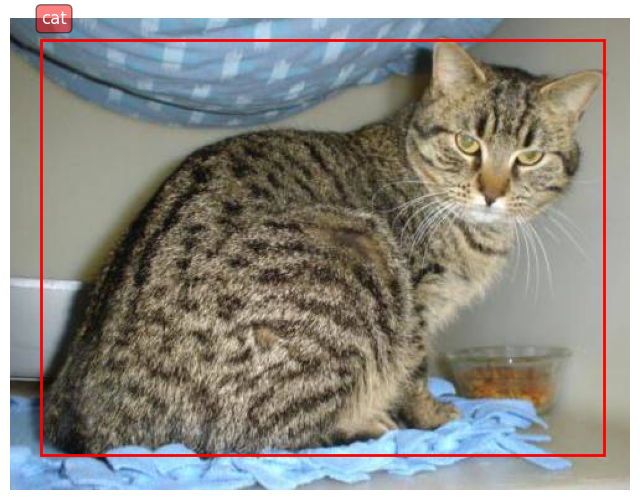

Пример собаки (index 555):


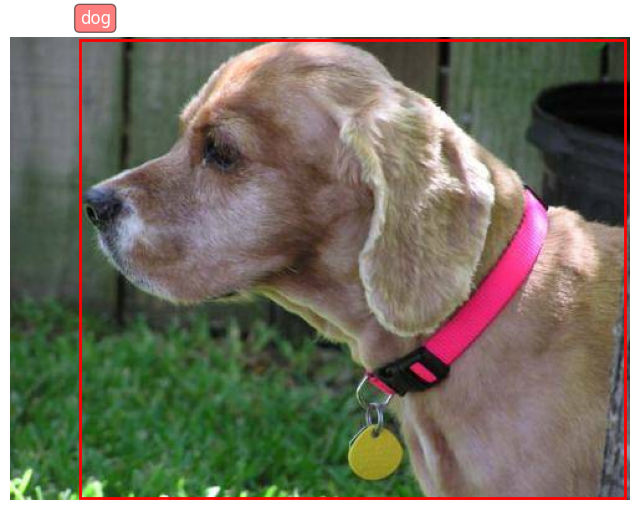

In [5]:
dataset_viz = AnimalDetectionDataset(
    root='animals',
    transforms=None,
    return_scaled=False 
)

def show_image_with_bounding_box(image, bbox_dict, label):
    """
    Визуализирует изображение с bounding box и названием класса.
    
    Args:
        image (PIL.Image.Image): Изображение.
        bbox_dict (dict): Словарь с ключами xmin, ymin, xmax, ymax.
        label (str): Название класса.
    """
    fig, ax = plt.subplots(1, figsize=(8, 8))
    
    ax.imshow(image)
    
    width = bbox_dict['xmax'] - bbox_dict['xmin']
    height = bbox_dict['ymax'] - bbox_dict['ymin']
    

    rect = patches.Rectangle(
        (bbox_dict['xmin'], bbox_dict['ymin']), 
        width, 
        height, 
        linewidth=2, 
        edgecolor='r',
        facecolor='none' 
    )
    ax.add_patch(rect)
    props = dict(boxstyle='round', facecolor='red', alpha=0.5)
    ax.text(
        bbox_dict['xmin'], 
        bbox_dict['ymin'] - 10,
        label, 
        fontsize=12, 
        color='white', 
        bbox=props,
        verticalalignment='bottom'
    )
    
    plt.axis('off')
    plt.show()


cat_idx = 111
dog_idx = 555

print(f"Пример кошки (index {cat_idx}):")
img_cat, bbox_cat, label_cat = dataset_viz[cat_idx]
show_image_with_bounding_box(img_cat, bbox_cat, label_cat)


print(f"Пример собаки (index {dog_idx}):")
img_dog, bbox_dog, label_dog = dataset_viz[dog_idx]
show_image_with_bounding_box(img_dog, bbox_dog, label_dog)

<p class="task" id="4"></p>

4\. Напишите модель для решения задачи выделения объектов. Реализуйте двухголовую сеть, одна голова которой предсказывает метку объекта (задача классификации), а вторая голова предсказывает 4 координаты вершин bounding box (задача регрессии). В качестве backbone используйте модель resnet50 из пакета `torchvision`.

- [ ] Проверено на семинаре

In [6]:
class ObjectDetector(pl.LightningModule):
    def __init__(
        self, 
        num_classes: int = 2, 
        learning_rate: float = 1e-4,
        freeze_backbone: bool = True
    ):
        super().__init__()
        self.save_hyperparameters()
        
        weights = models.ResNet50_Weights.DEFAULT
        backbone = models.resnet50(weights=weights)
        
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
        
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # Размер вектора признаков у ResNet50 равен 2048
        feature_dim = 2048
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
        
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feature_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 4)
        )
        
        self.cls_criterion = nn.CrossEntropyLoss()
        self.reg_criterion = nn.MSELoss()

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # [Batch, 3, H, W]
        
        features = self.backbone(x)
        
        class_logits = self.classifier(features)
        bbox_coords = self.regressor(features)
        
        return class_logits, bbox_coords

    def training_step(self, batch, batch_idx):
        images, bbox_targets, labels = batch
        
        targets = torch.stack([
            bbox_targets['xmin'], 
            bbox_targets['ymin'], 
            bbox_targets['xmax'], 
            bbox_targets['ymax']
        ], dim=1).float()
        
        class_logits, pred_bboxes = self(images)
        
        loss_cls = self.cls_criterion(class_logits, labels)
        loss_bbox = self.reg_criterion(pred_bboxes, targets)
        
        total_loss = loss_cls + loss_bbox
        
        self.log("train_loss", total_loss, prog_bar=True)
        self.log("train_loss_cls", loss_cls, prog_bar=True)
        self.log("train_loss_bbox", loss_bbox, prog_bar=True)
        
        return total_loss

    def validation_step(self, batch, batch_idx):
        images, bbox_targets, labels = batch
        
        targets = torch.stack([
            bbox_targets['xmin'], 
            bbox_targets['ymin'], 
            bbox_targets['xmax'], 
            bbox_targets['ymax']
        ], dim=1).float()
        
        class_logits, pred_bboxes = self(images)
        
        loss_cls = self.cls_criterion(class_logits, labels)
        loss_bbox = self.reg_criterion(pred_bboxes, targets)
        total_loss = loss_cls + loss_bbox
        
        self.log("val_loss", total_loss, prog_bar=True)
        self.log("val_loss_cls", loss_cls)
        self.log("val_loss_bbox", loss_bbox)
        
        return total_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

model = ObjectDetector(num_classes=2)
print("Архитектура модели создана успешно.")
print(model)

Архитектура модели создана успешно.
ObjectDetector(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsam

<p class="task" id="5"></p>

5\. Разбейте набор данных на обучающее и валидационное множество. Обучите модель, описанную в задаче 4. При создании датасета не забудьте указать преобразования, соответствующие модели ResNet. 

Используйте сумму MSELoss (для расчета ошибки на задаче регрессии) и CrossEntropyLoss (для расчета ошибки на задачи классификации) для настройки весов модели. Для ускорения процесса обучения слои backbone можно заморозить. Во время обучения выводите на экран значения функции потерь на обучающем и валидационном множестве. Используя обученную модель, получите предсказания для изображения кошки и собаки и отрисуйте их. Выполните процедуру, обратную нормализации, чтобы корректно отобразить фотографии.

- [ ] Проверено на семинаре

In [7]:
def run_screenshot_script(url, output_path, width=1920, height=1480, sleep=5):
    """Запускает Playwright в подпроцессе для снятия скриншота."""
    script_code = """
import sys
import time
from playwright.sync_api import sync_playwright

def take_screenshot(url, output_path, width, height, sleep):
    try:
        with sync_playwright() as p:
            browser = p.chromium.launch()
            page = browser.new_page()
            page.set_viewport_size({"width": int(width), "height": int(height)})
            page.goto(url)
            time.sleep(int(sleep)) 
            page.screenshot(path=output_path, full_page=True)
            browser.close()
        print(f"Picture saved: {output_path}")
    except Exception as e:
        print(f"Error: {e}", file=sys.stderr)
        sys.exit(1)

if __name__ == "__main__":
    take_screenshot(sys.argv[1], sys.argv[2], sys.argv[3], sys.argv[4], sys.argv[5])
"""
    try:
        subprocess.run(
            [sys.executable, "-c", script_code, url, output_path, str(width), str(height), str(sleep)],
            capture_output=True, text=True, check=True
        )
        print(f"📸 Скриншот сохранен: {output_path}")
    except subprocess.CalledProcessError as e:
        print(f"❌ Ошибка скриншота:\n{e.stderr}", file=sys.stderr)



if 'mlflow_process' in locals() and mlflow_process.poll() is None:
    mlflow_process.terminate()
    mlflow_process.wait()

port = 5000
mlflow_tracking_uri = "file:./mlruns"
experiment_name = "Cat_Dog_Trainer"

mlflow_process = subprocess.Popen(
    ["mlflow", "ui", "--port", str(port), "--backend-store-uri", mlflow_tracking_uri],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL
)
print(f"🚀 MLflow UI запущен на http://localhost:{port}")
print(f"PID: {mlflow_process.pid}")

# Настраиваем клиент
mlflow.set_tracking_uri(mlflow_tracking_uri)
mlflow.set_experiment(experiment_name)

🚀 MLflow UI запущен на http://localhost:5000
PID: 31900


<Experiment: artifact_location='file:c:/Projects/FU/Course_3/DL/mlruns/114105423149237522', creation_time=1765103179181, experiment_id='114105423149237522', last_update_time=1765103179181, lifecycle_stage='active', name='Cat_Dog_Trainer', tags={}>

In [23]:
# Константы ImageNet (стандарт для ResNet)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

def get_transforms(train=True):
    transforms_list = [
        T.Resize((224, 224), antialias=True),
        T.ToImage(),                        
        T.ToDtype(torch.float32, scale=True), 
        T.Normalize(mean=MEAN, std=STD)
    ]
    return T.Compose(transforms_list)

label_map = {'cat': 0, 'dog': 1}
def target_transform(label: str) -> int:
    return label_map[label]

inv_label_map = {v: k for k, v in label_map.items()}




In [ ]:
class AnimalDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=32, val_split=0.2):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.val_split = val_split
        self.dataset = None
        self.train_idx = None
        self.val_idx = None

    def setup(self, stage=None):
        full_dataset = AnimalDetectionDataset(
            root=self.data_dir,
            transforms=get_transforms(train=True),
            target_transform=target_transform,
            return_scaled=True 
        )
        
        labels = []
        for xml_path in full_dataset.xml_paths:
            tree = ET.parse(xml_path)
            name = tree.getroot().find('object').find('name').text
            labels.append(label_map[name])
            
        indices = np.arange(len(full_dataset))
        
        train_idx, val_idx = train_test_split(
            indices, 
            test_size=self.val_split, 
            stratify=labels, 
            random_state=42
        )
        
        self.train_ds = Subset(full_dataset, train_idx)
        self.val_ds = Subset(full_dataset, val_idx)
        print(f"Train size: {len(self.train_ds)}, Val size: {len(self.val_ds)}")

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=5)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False, num_workers=5)

In [38]:
mlflow_logger = MLFlowLogger(
    experiment_name="Cat_Dog_Trainer",
    tracking_uri="file:./mlruns"
)

dm = AnimalDataModule(data_dir='animals', batch_size=16)
model = ObjectDetector(
    num_classes=2, 
    learning_rate=1e-3, 
    freeze_backbone=True
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
)

trainer = pl.Trainer(
    max_epochs=20,
    logger=mlflow_logger,
    callbacks=[checkpoint_callback],
    log_every_n_steps=1,
    accelerator="auto" 
)

trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Projects\FU\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:751: Checkpoint directory C:\Projects\FU\Course_3\DL\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | backbone      | Sequential       | 23.5 M | train
1 | classifier    | Sequential       | 1.1 M  | train
2 | regressor     | Sequential       | 1.1 M  | train
3 | cls_criterion | CrossEntropyLoss | 0      | train
4 | reg_criterion | MSELoss          | 0      | train
-----------------------------------------------------------
2.1 M     Trainable params
23.5 M    Non-trainable params
25.6 M    Total params
102.437   Total estimated model params size (MB)
164       Modules in train mode
0         Modules in eval mode


Train size: 880, Val size: 220


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Projects\FU\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Projects\FU\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


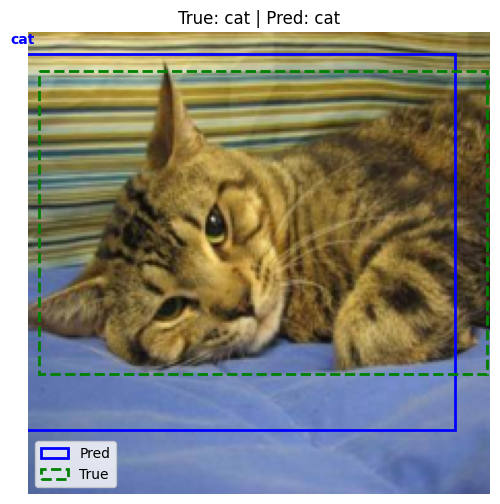

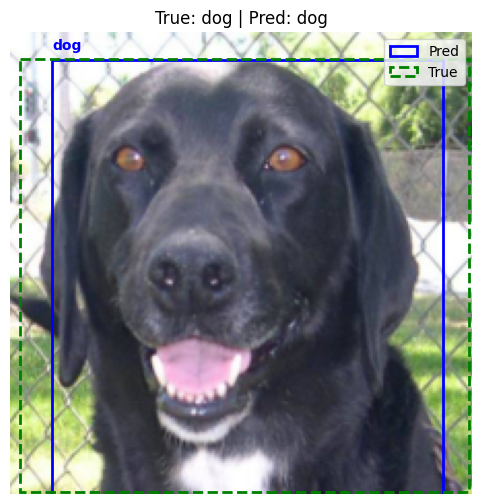

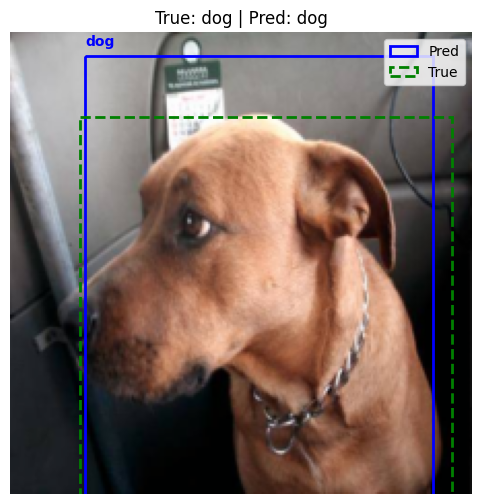

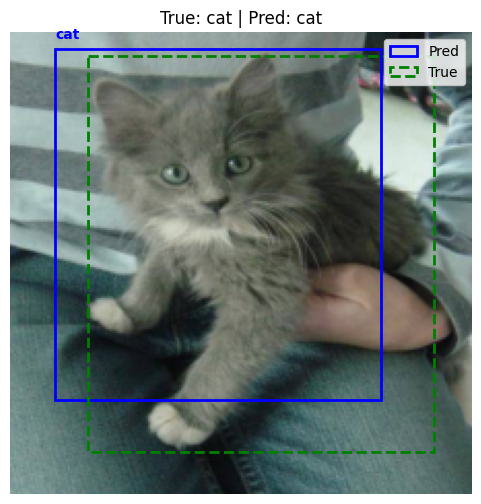

In [39]:
def visualize_prediction(model, dataset, idx):
    model.eval()
    image_tensor, bbox_target, label_target = dataset[idx]
    
    input_tensor = image_tensor.unsqueeze(0).to(model.device)
    
    with torch.no_grad():
        logits, pred_bbox = model(input_tensor)
        
    pred_label_idx = torch.argmax(logits, dim=1).item()
    pred_label_str = inv_label_map[pred_label_idx]
    
    pred_bbox = pred_bbox[0].cpu().numpy() 
    
    inv_normalize = T.Normalize(
        mean=[-m/s for m, s in zip(MEAN, STD)],
        std=[1/s for s in STD]
    )
    original_image = inv_normalize(image_tensor)
    original_image = original_image.permute(1, 2, 0).numpy()
    original_image = np.clip(original_image, 0, 1)
    
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(original_image)
    
    h, w, _ = original_image.shape
    
    xmin, ymin, xmax, ymax = pred_bbox
    rect = patches.Rectangle(
        (xmin * w, ymin * h), 
        (xmax - xmin) * w, 
        (ymax - ymin) * h, 
        linewidth=2, edgecolor='blue', facecolor='none', label='Pred'
    )
    ax.add_patch(rect)
    ax.text(xmin * w, ymin * h - 5, f"{pred_label_str}", color='blue', fontweight='bold')
    
    t_xmin, t_ymin, t_xmax, t_ymax = bbox_target['xmin'], bbox_target['ymin'], bbox_target['xmax'], bbox_target['ymax']
    rect_true = patches.Rectangle(
        (t_xmin * w, t_ymin * h), 
        (t_xmax - t_xmin) * w, 
        (t_ymax - t_ymin) * h, 
        linewidth=2, edgecolor='green', linestyle='--', facecolor='none', label='True'
    )
    ax.add_patch(rect_true)
    
    plt.legend()
    plt.title(f"True: {inv_label_map[label_target]} | Pred: {pred_label_str}")
    plt.axis('off')
    plt.show()

model.to("cpu") 
val_dataset = dm.val_ds
PREDS = 4

for i in torch.randint(0, len(val_dataset),(PREDS,)):
    visualize_prediction(model, val_dataset, i)

📸 Скриншот сохранен: images/run_metrics_7d7392e6107244a881cf76e8ba26ec98.png


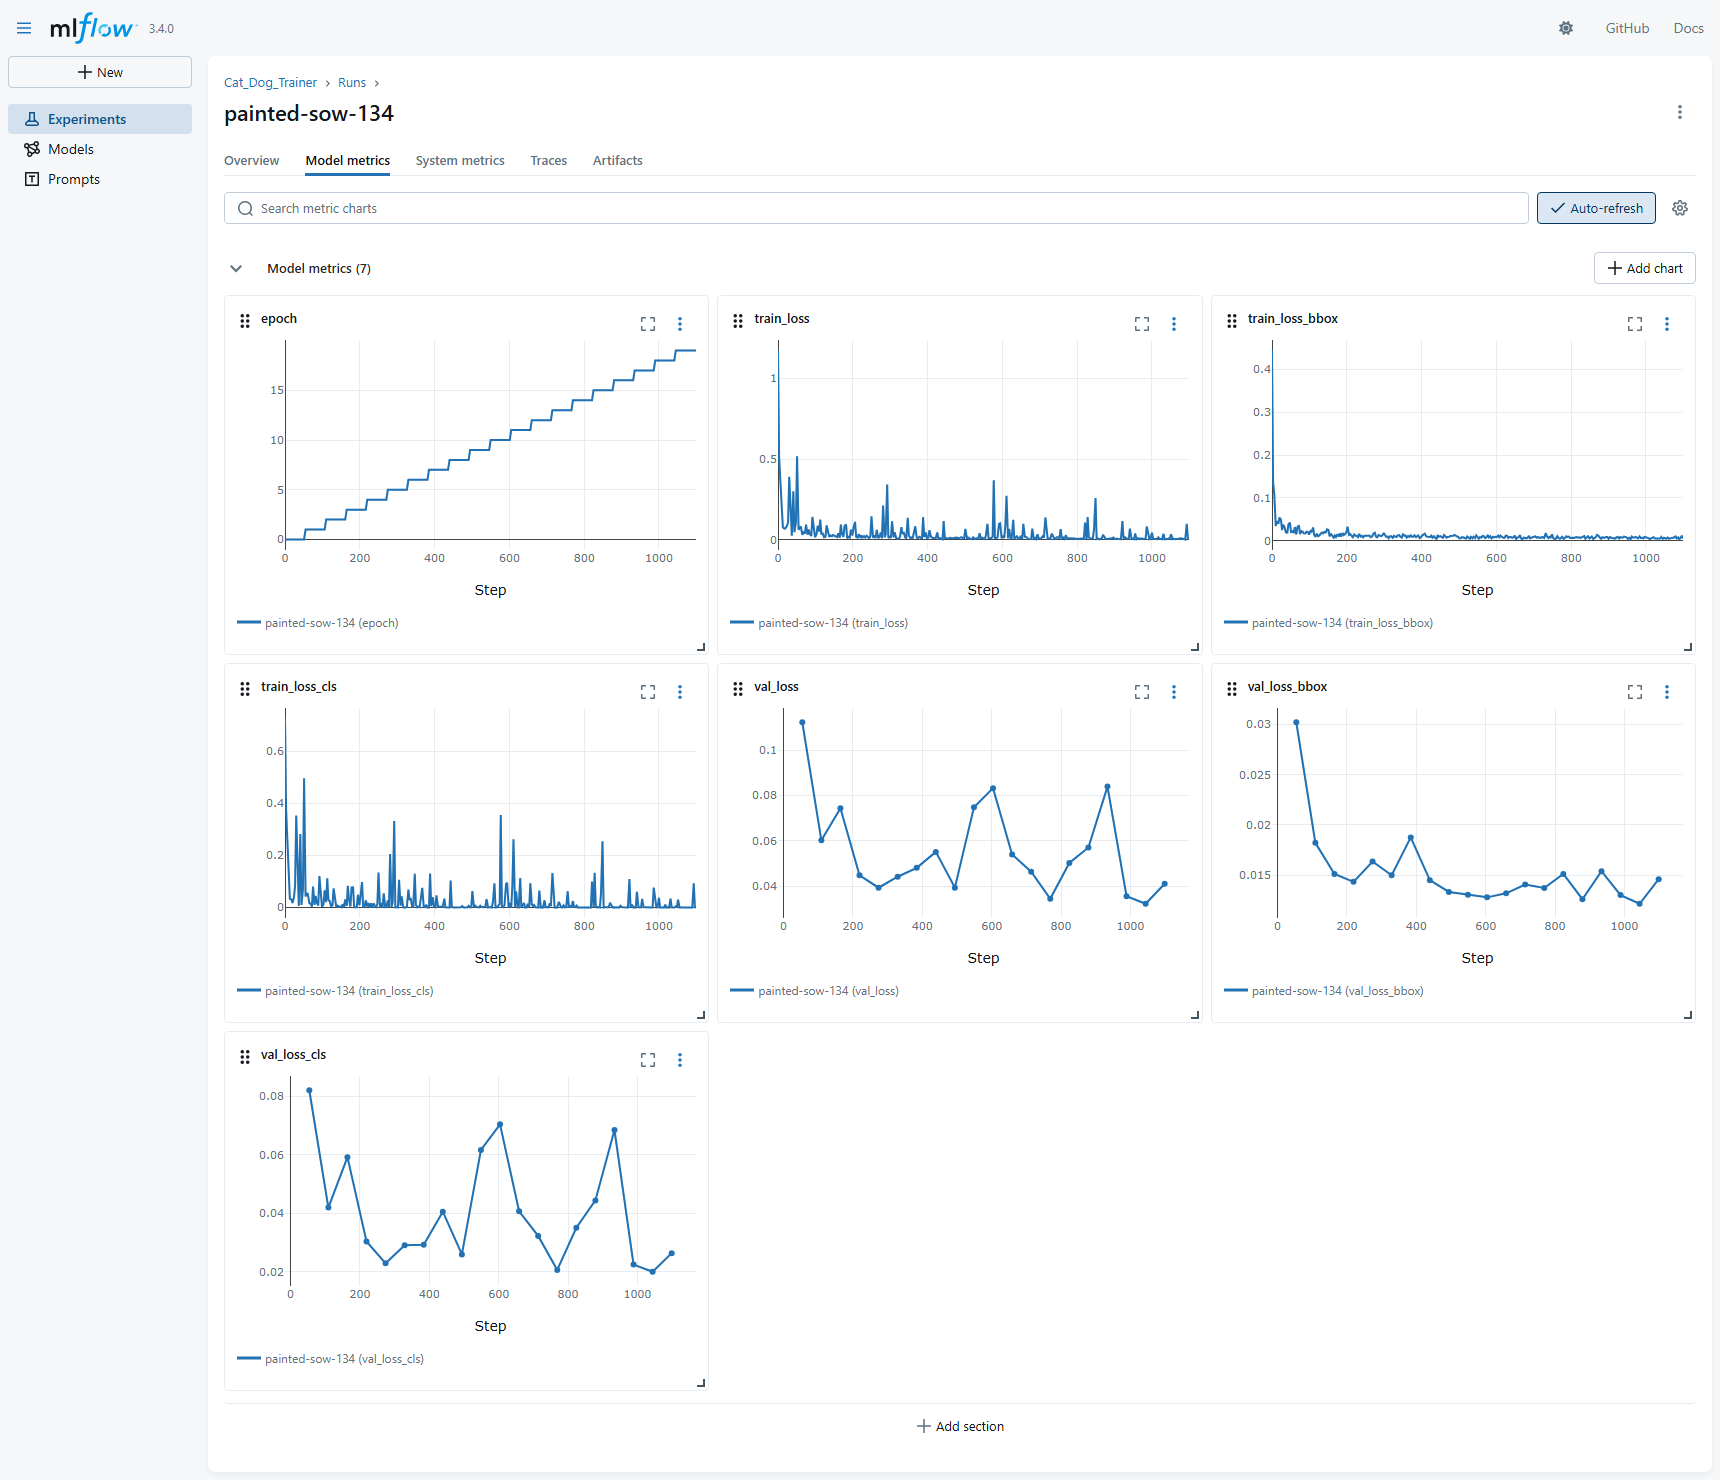

In [ ]:
runs = mlflow.search_runs(experiment_ids=[mlflow.get_experiment_by_name(experiment_name).experiment_id])
id = mlflow.search_runs(experiment_ids=[mlflow.get_experiment_by_name(experiment_name).experiment_id]).dropna().index[0]
run_id = runs.iloc[id].run_id
experiment_id = runs.iloc[id].experiment_id


run_url = f"http://localhost:{port}/#/experiments/{experiment_id}/runs/{run_id}"

os.makedirs("images", exist_ok=True)
screenshot_path = f"images/run_metrics_{run_id}.png"

try:
    target_url = run_url + "/model-metrics" 
    run_screenshot_script(target_url, screenshot_path, 1720, 1480, 5)
    
    display(dispImage(filename=screenshot_path))
except Exception as e:
    print(f"Could not display screenshot: {e}")

<p class="task" id="6"></p>

6\. Найдите в сети несколько изображений котов и собак. Используя любой инструмент для разметки (например, [CVAT](https://www.cvat.ai/)), выделите котов и собак на изображениях. Вставьте скриншот экспортированного файла с разметкой. Используя полученные изображения, визуализируйте разметку и bounding boxes, полученные при помощи модели.

- [ ] Проверено на семинаре

In [ ]:
prepare_data(r'test_animals\job_3356725_annotations_2025_12_07_11_03_10_pascal voc 1.1', r'test_animals\job_3356725_annotations_2025_12_07_11_03_10_pascal voc 1.1.zip')

Распаковка архива test_animals\job_3356725_annotations_2025_12_07_11_03_10_pascal voc 1.1.zip...
Архив успешно распакован.


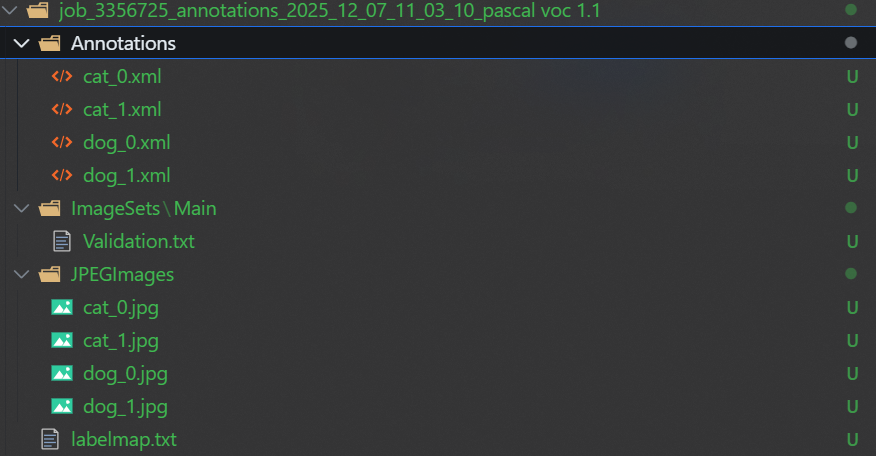

Найдено изображений: 4
Обработка: cat_0.jpg


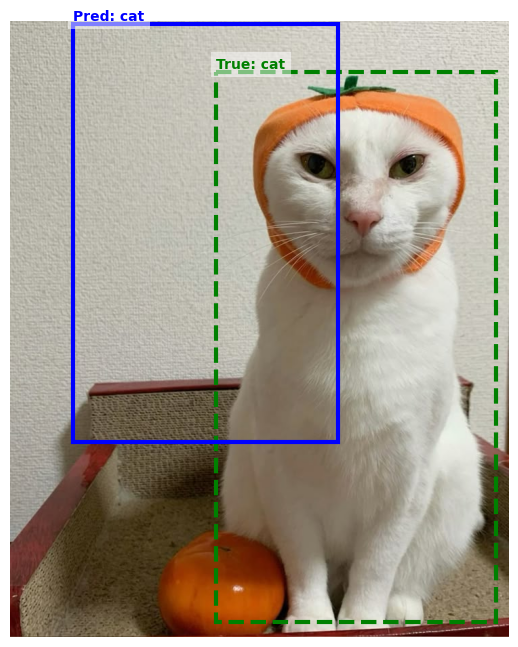

Обработка: cat_1.jpg


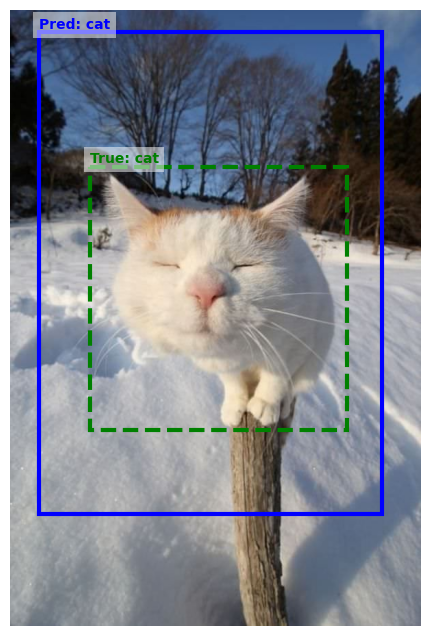

Обработка: dog_0.jpg


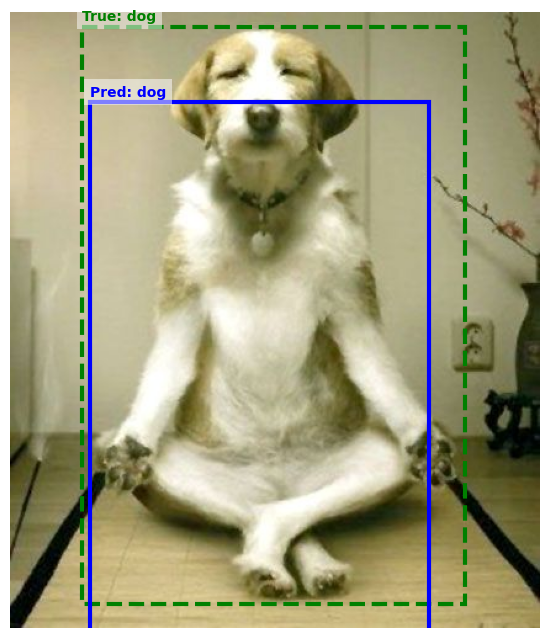

Обработка: dog_1.jpg


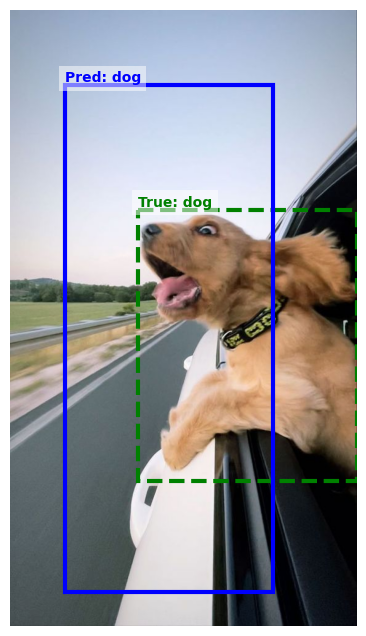

In [ ]:
MY_DATA_DIR = Path(r'test_animals\job_3356725_annotations_2025_12_07_11_03_10_pascal voc 1.1') 

def predict_and_plot_custom(image_path, xml_path, model):
    image = Image.open(image_path).convert("RGB")
    orig_w, orig_h = image.size
    
    transform = get_transforms(train=False)
    
    input_tensor = transform(image) 
    input_tensor = input_tensor.unsqueeze(0).to(model.device)

    model.eval()
    with torch.no_grad():
        logits, pred_bbox = model(input_tensor)
    
    pred_label_idx = torch.argmax(logits, dim=1).item()
    pred_label_str = inv_label_map[pred_label_idx] # 'cat' или 'dog'
    
    px, py, px2, py2 = pred_bbox[0].cpu().numpy()
    pred_rect = [px * orig_w, py * orig_h, px2 * orig_w, py2 * orig_h]

    tree = ET.parse(xml_path)
    root = tree.getroot()
    obj = root.find('object')
    true_label = obj.find('name').text
    bndbox = obj.find('bndbox')
    true_rect = [
        float(bndbox.find('xmin').text),
        float(bndbox.find('ymin').text),
        float(bndbox.find('xmax').text),
        float(bndbox.find('ymax').text)
    ]

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)
    
    def draw_box(coords, color, label, style='-'):
        xmin, ymin, xmax, ymax = coords
        width = xmax - xmin
        height = ymax - ymin
        rect = patches.Rectangle(
            (xmin, ymin), width, height, 
            linewidth=3, edgecolor=color, facecolor='none', linestyle=style, label=label
        )
        ax.add_patch(rect)
        ax.text(xmin, ymin-5, label, color=color, fontweight='bold', 
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    draw_box(true_rect, 'green', f'True: {true_label}', '--')
    draw_box(pred_rect, 'blue', f'Pred: {pred_label_str}')
    
    plt.axis('off')
    plt.show()



img_folder = MY_DATA_DIR / 'JPEGImages'
xml_folder = MY_DATA_DIR / 'Annotations'

if not img_folder.exists():
    print(f"Папка {img_folder} не найдена")
else:
    images = sorted(list(img_folder.glob('*.jpg')) + list(img_folder.glob('*.jpeg')))
    print(f"Найдено изображений: {len(images)}")

    for img_p in images:
        xml_p = xml_folder / img_p.with_suffix('.xml').name
        
        if xml_p.exists():
            print(f"Обработка: {img_p.name}")
            predict_and_plot_custom(img_p, xml_p, model)
        else:
            print(f"Нет XML для {img_p.name}")